In [1]:
## Imports
# import os
from pathlib import Path
# import shutil
import warnings
import opendatasets as od
from typing import Optional, Callable, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import torch
# import torchvision
from torch.utils.data import random_split
from torchvision.datasets.vision import VisionDataset

In [2]:
## Simulate the args like in the `main_*.py` files
class ARGS:
    num_users:int = 100

args = ARGS()
args.num_users

100

In [3]:
## Define custom CobaDataset class
class COBA(VisionDataset):
    """
    `COBA <https://www.kaggle.com/datasets/earltankardjr/coba-iobt-dataset> Dataset`
    Args:
        root (string): Root directory of dataset where ``COBA/raw/data.pt``
            and  ``COBA/raw/targets.pt`` exist.
        train (bool, optional): If `True`, creates dataset from ``training.pt``,
            otherwise from ``test.pt``. -- This currently doesn't do anything!
        download (bool, optional): If `True`, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    resources:list = ["https://www.kaggle.com/datasets/earltankardjr/coba-iobt-dataset"] # link(s) to coba dataset
    training_file:str = "training.pt"
    test_file:str = "test.pt"
    # training_file:str = "training.pt"
    # test_file:str = "test.pt"
    classes:list = ["0 - airplane",
                    "1 - ambulance",
                    "2 - briefcase",
                    "3 - cannon",
                    "4 - car",
                    "5 - civilian",
                    "6 - dagger",
                    "7 - dog",
                    "8 - handgun",
                    "9 - missilerocket",
                    "10 - rifle",
                    "11 - soldier",
                    "12 - tank",
                    "13 - truck"
    ]

    
    @property
    def train_labels(self) -> torch.Tensor:
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self) -> torch.Tensor:
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self) -> torch.Tensor:
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self) -> torch.Tensor:
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(self, root:str, train:bool=True, transform:Optional[Callable]=None, target_transform: Optional[Callable]=None, download:bool=False) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        
        self.data, self.targets = self._load_data()


    def download(self) -> None:
        if self._check_exists():
            return

        # Make Raw directory
        Path.mkdir(self.raw_folder, exist_ok=True, parents=True)

        # Download dataset file
        coba_dataset_url:str = self.resources[0]
        od.download(coba_dataset_url)

        ## Move dataset
        coba_iobt_npy_file:str = "iobt_128_128.npy"

        downloaded_coba_dataset_path = Path.cwd().joinpath("coba-iobt-dataset", coba_iobt_npy_file)
        
        if not downloaded_coba_dataset_path.exists():
            raise Exception("Failed to download and locate COBA dataset")
        
        new_coba_dataset_path = Path.cwd().joinpath(self.raw_folder, coba_iobt_npy_file)
        downloaded_coba_dataset_path.rename(new_coba_dataset_path)
        
        ## Format dataset
        with open(new_coba_dataset_path, "rb") as f:
            data = torch.tensor(np.load(f), dtype=torch.float32)
            targets = torch.tensor(np.load(f, allow_pickle=True), dtype=torch.int64)

        ## Save dataset
        torch.save(data, self.raw_folder.joinpath("data.pt"))
        torch.save(targets, self.raw_folder.joinpath("targets.pt"))
        
        ## Delete unnecessary files/directories
        Path.rmdir(Path.cwd().joinpath("coba-iobt-dataset"))
        Path.unlink(Path.cwd().joinpath(self.raw_folder, coba_iobt_npy_file))

    def _load_data(self) -> Tuple[torch.Tensor, torch.Tensor]:
        image_file:str = "data.pt"
        data = torch.load(Path.cwd().joinpath(self.raw_folder, image_file))
        
        label_file:str = "targets.pt"
        targets = torch.load(Path.cwd().joinpath(self.raw_folder, label_file))

        return data, targets


    def __len__(self) -> int:
        return len(self.data)
        # return len(self.labels)

    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = self.data[idx]
        label = self.targets[idx]
        # label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            target = self.target_transform(target)
        
        return image, label

    @property
    def raw_folder(self) -> Path:
        return Path(self.root, self.__class__.__name__, "raw")

    @property
    def processed_folder(self) -> Path:
        return Path(self.root, self.__class__.__name__, "processed")

    @property
    def class_to_idx(self) -> Dict[int, str]:
        # class_dict:dict[int,str] = {int(label.replace(" ","").split("-")[0]): label.replace(" ","").split("-")[1] for label in self.classes} #one liner
        class_dict:Dict[int,str] = {}
        for label in self.classes:
            encoded_val, name = label.replace(" ","").split("-")
            class_dict[int(encoded_val)] = name
        return class_dict

    def _check_exists(self) -> bool:
        return Path.exists(Path(self.raw_folder, "data.pt")) and Path.exists(Path(self.raw_folder, "targets.pt"))
        # return (Path.exists(Path.joinpath(self.raw_folder, self.training_file)) and Path.exists(Path.joinpath(self.raw_folder, self.test_file)))

In [4]:
## Initialize CobaDataset
coba_dataset = COBA(root="data/coba", download=True)

In [5]:
## Create training and testing data -- method 1
train_size = int(0.8 * len(coba_dataset))
test_size = len(coba_dataset) - train_size
train_dataset, test_dataset = random_split(dataset=coba_dataset, lengths=[train_size, test_size])

In [6]:
len(train_dataset.indices)

7046

Label: soldier


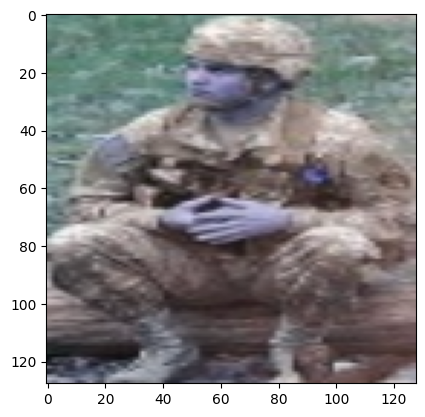

In [7]:
## Plot random train sample
example_image = coba_dataset[np.random.choice(train_dataset.indices, 1).item()]
img, label = example_image
label_encodings = train_dataset.dataset.class_to_idx

print(f"Label: {label_encodings[label.item()]}")
plt.imshow(img)

In [8]:
## The random split works!
dups = 0
for index in test_dataset.indices:
    if index in train_dataset.indices:
        dups += 1
print(dups)        

0


In [9]:
# Try iid example
def iid(dataset, num_users):
    """
    Sample I.I.D. client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [10]:
dict_users_train = iid(dataset=train_dataset.dataset, num_users=100)
for user,d in dict_users_train.items():
    print(f"user:{user}\t\t len:{len(d)}")

user:0		 len:88
user:1		 len:88
user:2		 len:88
user:3		 len:88
user:4		 len:88
user:5		 len:88
user:6		 len:88
user:7		 len:88
user:8		 len:88
user:9		 len:88
user:10		 len:88
user:11		 len:88
user:12		 len:88
user:13		 len:88
user:14		 len:88
user:15		 len:88
user:16		 len:88
user:17		 len:88
user:18		 len:88
user:19		 len:88
user:20		 len:88
user:21		 len:88
user:22		 len:88
user:23		 len:88
user:24		 len:88
user:25		 len:88
user:26		 len:88
user:27		 len:88
user:28		 len:88
user:29		 len:88
user:30		 len:88
user:31		 len:88
user:32		 len:88
user:33		 len:88
user:34		 len:88
user:35		 len:88
user:36		 len:88
user:37		 len:88
user:38		 len:88
user:39		 len:88
user:40		 len:88
user:41		 len:88
user:42		 len:88
user:43		 len:88
user:44		 len:88
user:45		 len:88
user:46		 len:88
user:47		 len:88
user:48		 len:88
user:49		 len:88
user:50		 len:88
user:51		 len:88
user:52		 len:88
user:53		 len:88
user:54		 len:88
user:55		 len:88
user:56		 len:88
user:57		 len:88
user:58		 len:88
user:59

In [11]:
## Try noniid example
import random

def noniid(dataset, num_users, shard_per_user, rand_set_all=[]):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    dict_users = {i: np.array([], dtype='int64') for i in range(num_users)}

    idxs_dict = {}
    for i in range(len(dataset)):
        # label = torch.tensor(dataset.targets[i]).item()
        label = dataset.targets[i].item()
        if label not in idxs_dict.keys():
            idxs_dict[label] = []
        idxs_dict[label].append(i)

    num_classes = len(np.unique(dataset.targets))
    shard_per_class = int(shard_per_user * num_users / num_classes)

    #debug
    print(f"num_classes: {num_classes}")
    print(f"shard_per_class: {shard_per_class}")
    
    for label in idxs_dict.keys():
        x = idxs_dict[label]
        num_leftover = len(x) % shard_per_class
        leftover = x[-num_leftover:] if num_leftover > 0 else []
        x = np.array(x[:-num_leftover]) if num_leftover > 0 else np.array(x)
        x = x.reshape((shard_per_class, -1))
        x = list(x)

        #debug
        # print(f"x: {x}")

        for i, idx in enumerate(leftover):
            x[i] = np.concatenate([x[i], [idx]])
        idxs_dict[label] = x

        #debug
        # print(f"idxs_dict: {idxs_dict}")

    if len(rand_set_all) == 0:
        rand_set_all = list(range(num_classes)) * shard_per_class
        random.shuffle(rand_set_all)
        
        #debug
        print(f"len(rand_set_all) = {len(rand_set_all)}")

        try:
            rand_set_all = np.array(rand_set_all).reshape((num_users, -1))
        except ValueError as ve:
            print(f"ValueError: {ve}\n\nAttempting to reshape...")
            for i in range(num_users,0,-1):
                try:
                    rand_set_all = np.array(rand_set_all).reshape((i, -1))
                    print(f"New num_users: {i}")
                    global args
                    args.num_users = i
                    num_users = i
                    break
                except ValueError:
                    continue
        print(f"rand_set_all.shape: {rand_set_all.shape}")
    
    # divide and assign
    for i in range(num_users):
        rand_set_label = rand_set_all[i]
        rand_set = []
        for label in rand_set_label:
            idx = np.random.choice(len(idxs_dict[label]), replace=False)
            rand_set.append(idxs_dict[label].pop(idx))
        dict_users[i] = np.concatenate(rand_set)

    dict_users = {key: val for key,val in dict_users.items() if len(val)}
    
    test = []
    for key, value in dict_users.items():
        # x = np.unique(torch.tensor(dataset.targets)[value])
        x = np.unique(dataset.targets[value])
        assert(len(x)) <= shard_per_user
        test.append(value)
    test = np.concatenate(test)
    assert(len(test) == len(dataset))
    assert(len(set(list(test))) == len(dataset))

    return dict_users, rand_set_all

In [12]:
dict_users_train, rand_set_all = noniid(dataset=train_dataset.dataset, num_users=100, shard_per_user=2)
for user,d in dict_users_train.items():
    print(f"user:{user}\t\t len:{len(d)}")

num_classes: 14
shard_per_class: 14
len(rand_set_all) = 196
ValueError: cannot reshape array of size 196 into shape (100,newaxis)

Attempting to reshape...
New num_users: 98
rand_set_all.shape: (98, 2)
user:0		 len:64
user:1		 len:217
user:2		 len:62
user:3		 len:65
user:4		 len:65
user:5		 len:62
user:6		 len:58
user:7		 len:88
user:8		 len:39
user:9		 len:95
user:10		 len:116
user:11		 len:47
user:12		 len:62
user:13		 len:32
user:14		 len:63
user:15		 len:92
user:16		 len:56
user:17		 len:217
user:18		 len:47
user:19		 len:64
user:20		 len:56
user:21		 len:56
user:22		 len:32
user:23		 len:65
user:24		 len:40
user:25		 len:65
user:26		 len:86
user:27		 len:93
user:28		 len:32
user:29		 len:47
user:30		 len:71
user:31		 len:270
user:32		 len:247
user:33		 len:84
user:34		 len:40
user:35		 len:56
user:36		 len:64
user:37		 len:241
user:38		 len:97
user:39		 len:119
user:40		 len:57
user:41		 len:65
user:42		 len:67
user:43		 len:224
user:44		 len:115
user:45		 len:93
user:46		 len:64


In [13]:
args.num_users

98

In [14]:
coba_dataset.class_to_idx

{0: 'airplane',
 1: 'ambulance',
 2: 'briefcase',
 3: 'cannon',
 4: 'car',
 5: 'civilian',
 6: 'dagger',
 7: 'dog',
 8: 'handgun',
 9: 'missilerocket',
 10: 'rifle',
 11: 'soldier',
 12: 'tank',
 13: 'truck'}